**Review**

Hi, my name is Dmitry and I will be reviewing your project.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did a great job! The project is accepted. Good luck on the next sprint!

# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [2]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [3]:
from sklearn.dummy import DummyClassifier

In [4]:
from lightgbm import LGBMClassifier

In [5]:
import math

import numpy as np
import pandas as pd
import spacy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

import spacy
import re
import random
#install wordcloud
!pip install wordcloud 
from wordcloud import WordCloud
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [7]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

In [8]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

## Load Data

In [9]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [10]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [11]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [12]:
df_reviews[df_reviews.isna().any(axis=1)]

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


In [13]:
df_reviews=df_reviews.dropna()

df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47329 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47329 non-null  object 
 1   title_type       47329 non-null  object 
 2   primary_title    47329 non-null  object 
 3   original_title   47329 non-null  object 
 4   start_year       47329 non-null  int64  
 5   end_year         47329 non-null  object 
 6   runtime_minutes  47329 non-null  object 
 7   is_adult         47329 non-null  int64  
 8   genres           47329 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47329 non-null  object 
 12  rating           47329 non-null  int64  
 13  sp               47329 non-null  object 
 14  pos              47329 non-null  int64  
 15  ds_part          47329 non-null  object 
 16  idx              47329 non-null  int64  
dtypes: Int64(1),

I removed the two null rows from our dataset. The data is prepared and ready for analysis. 

<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was loaded and inspected!

</div>

## EDA

Let's check the number of movies and reviews over years.

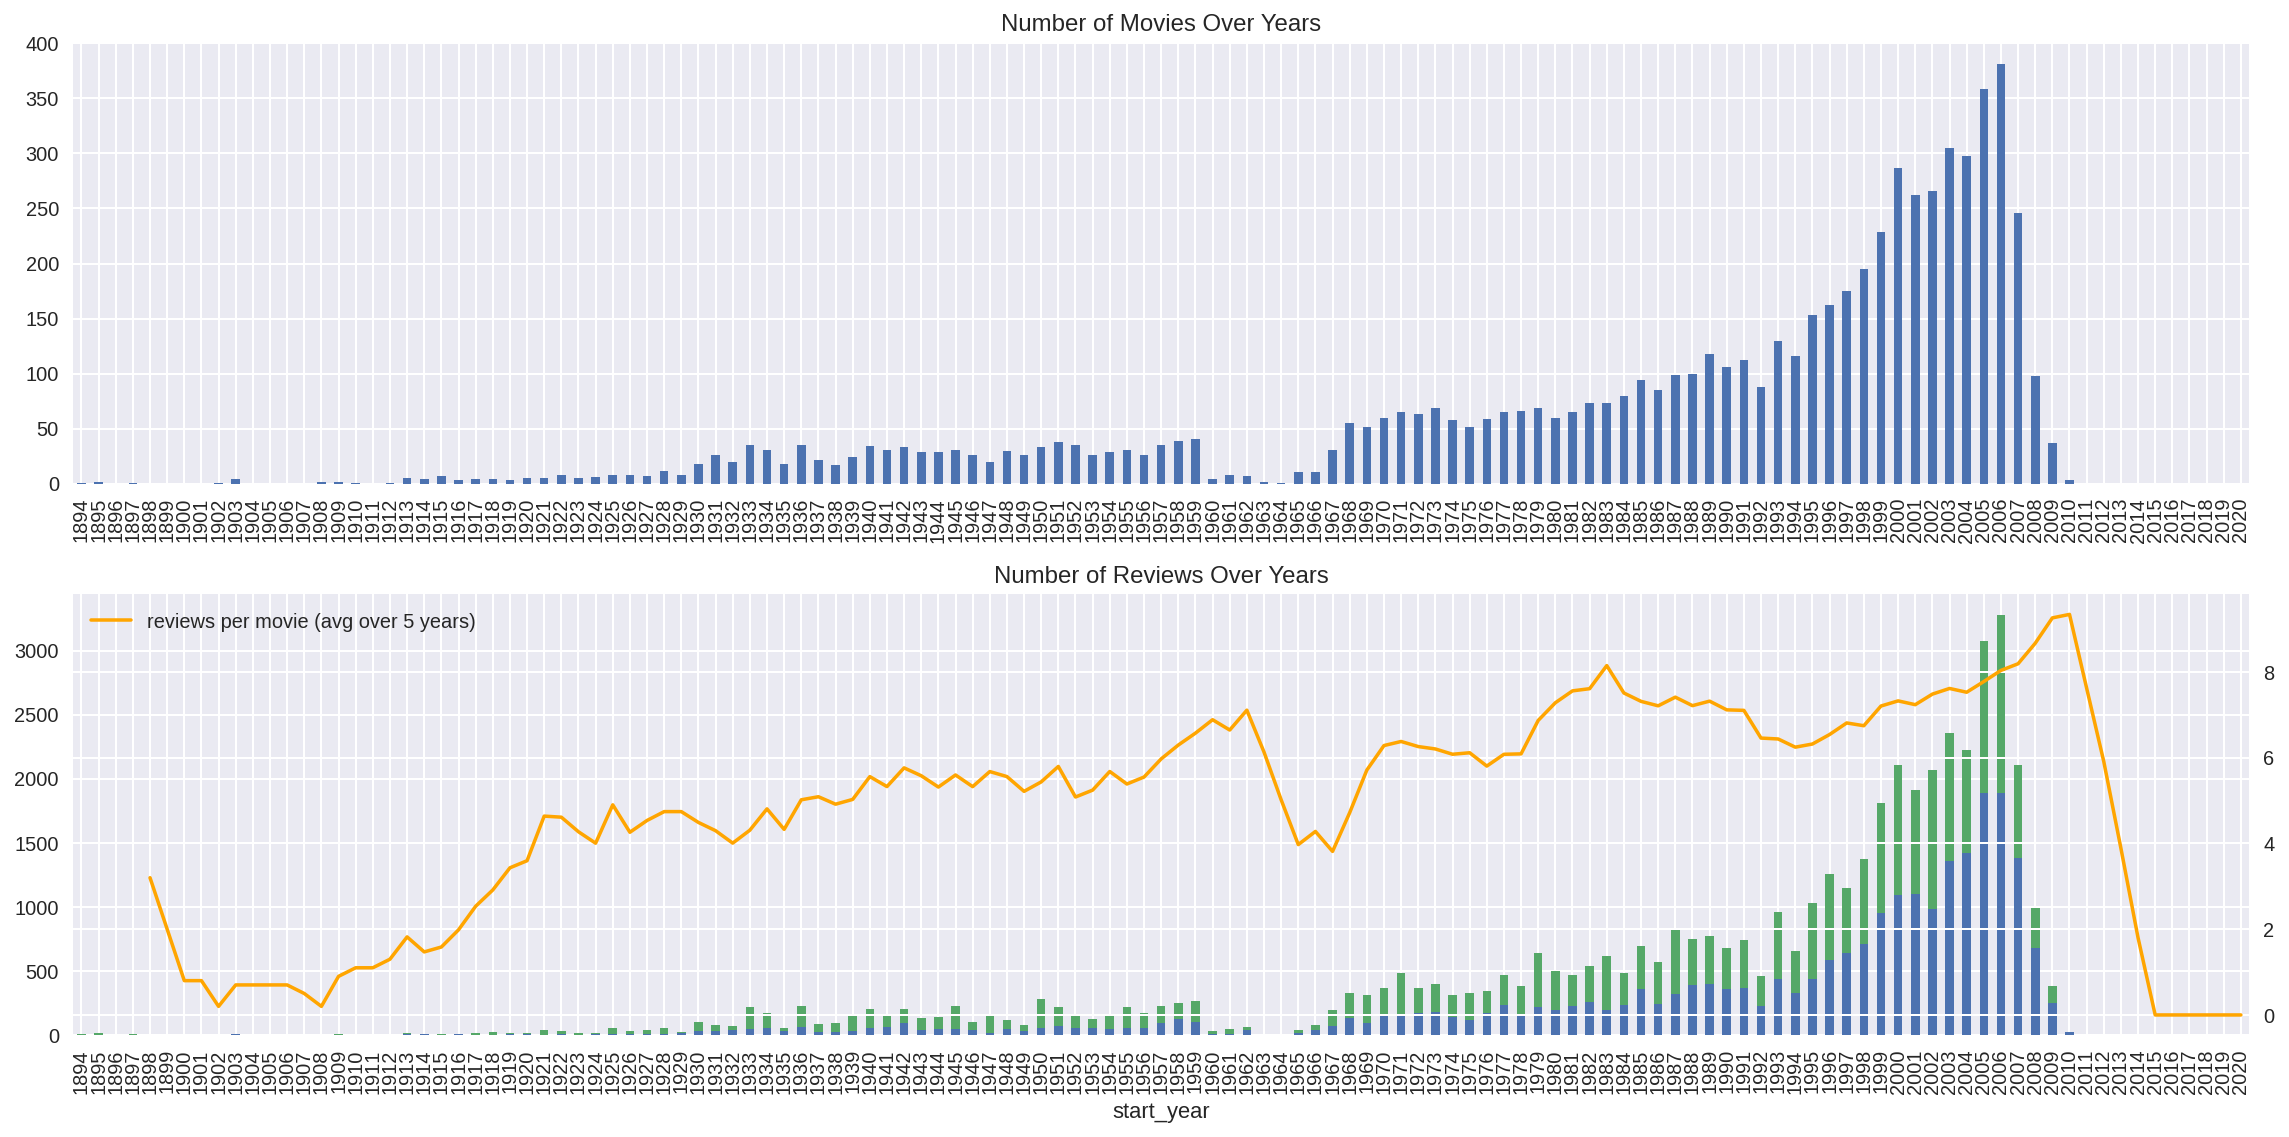

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

The trend of movies matches the trend of reviews. A large increase has occured in the 90s.

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

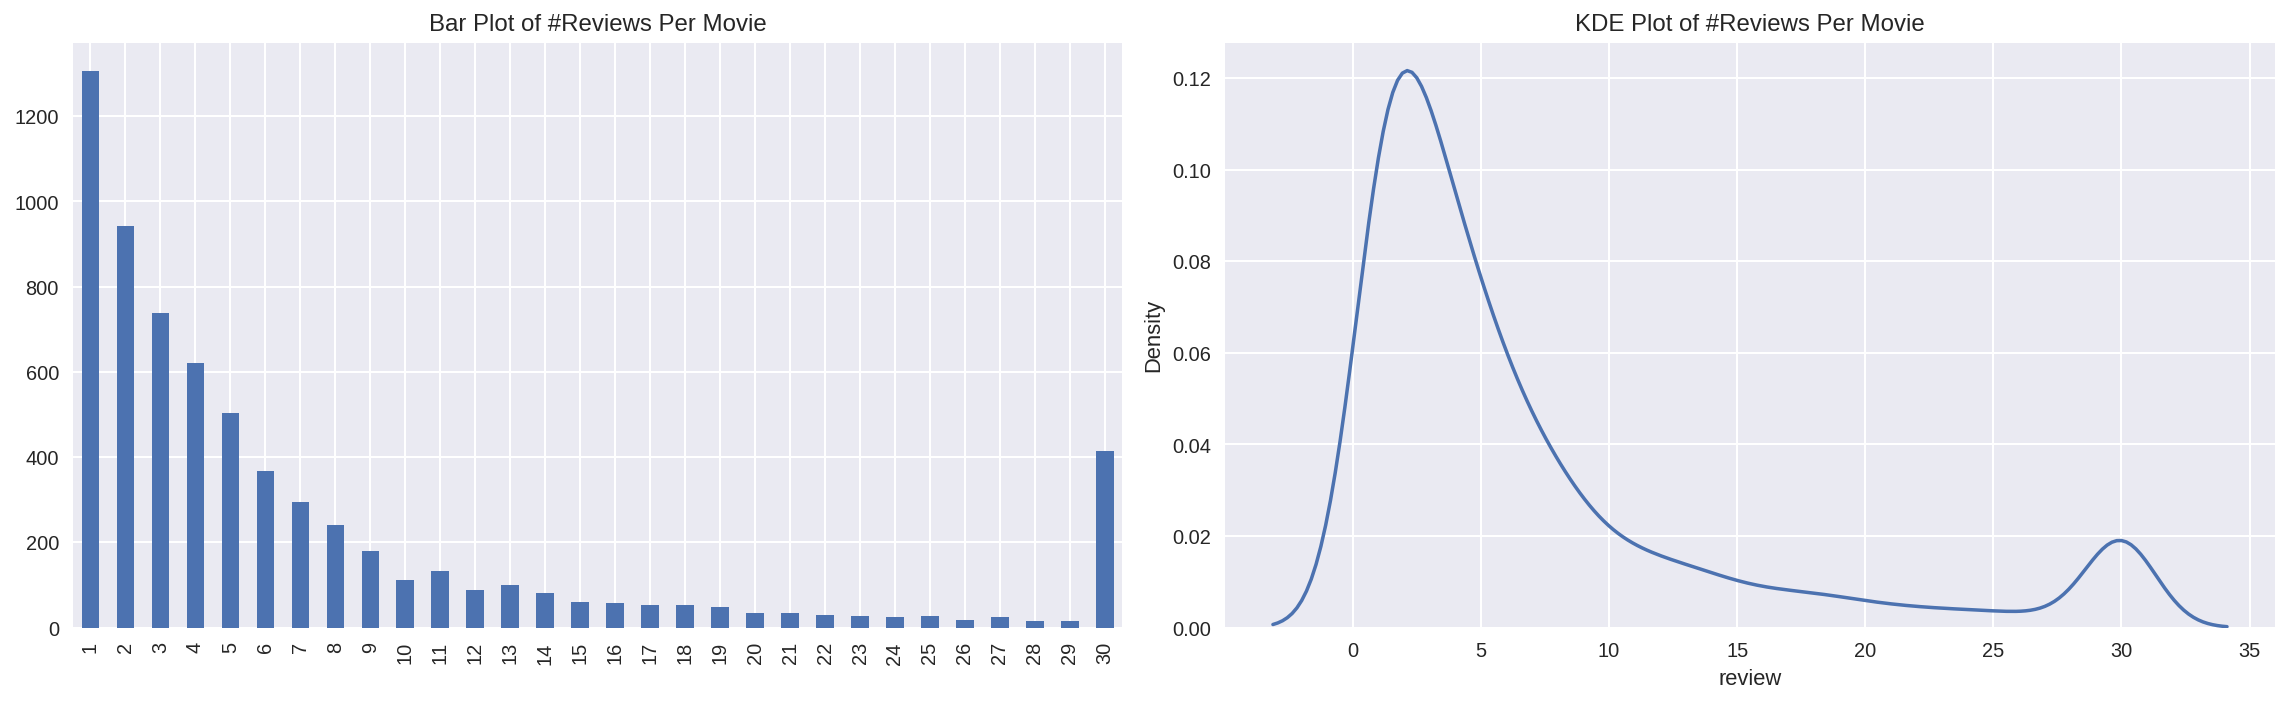

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

the bar graph is squewed to the left most movies only have one or a few reviews. 

In [16]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

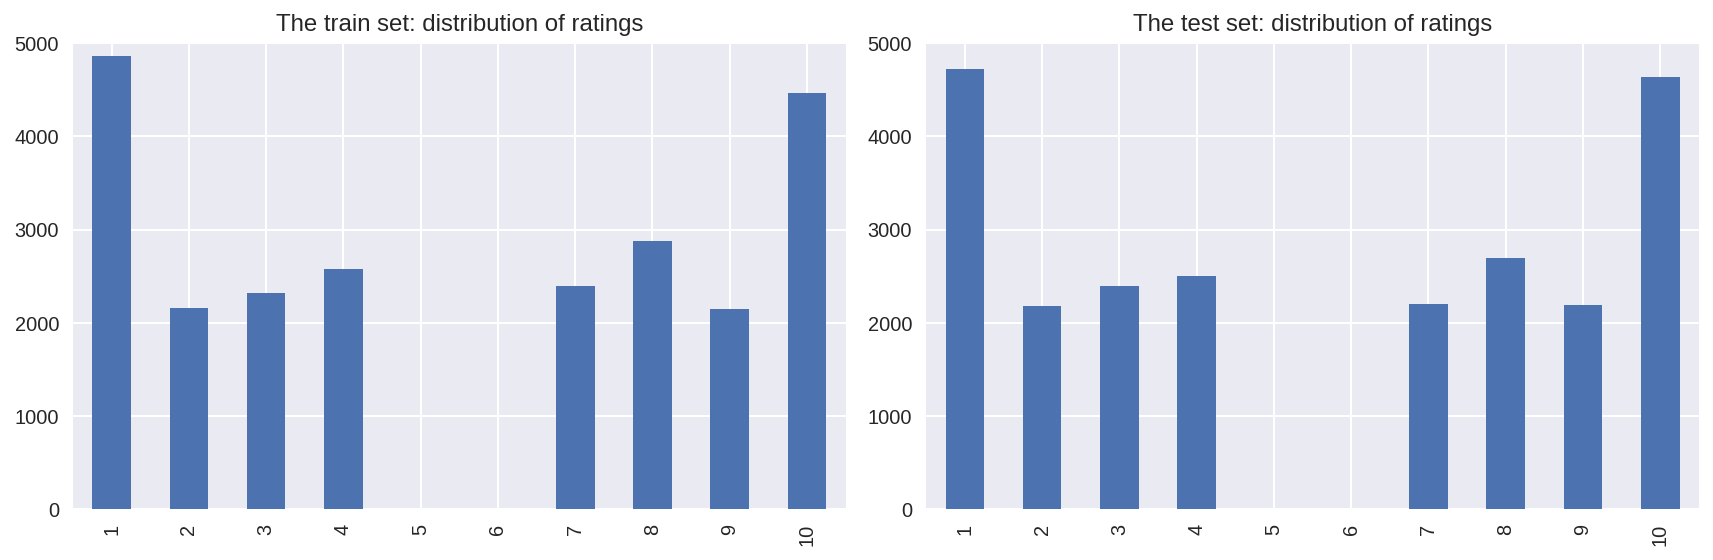

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

there is a polarity, most reviews get 1 or 10. With a similar distribution between the other numbers, around 2500. It is strange that there are no reviews recieving a score of 5 or 6. 


### Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


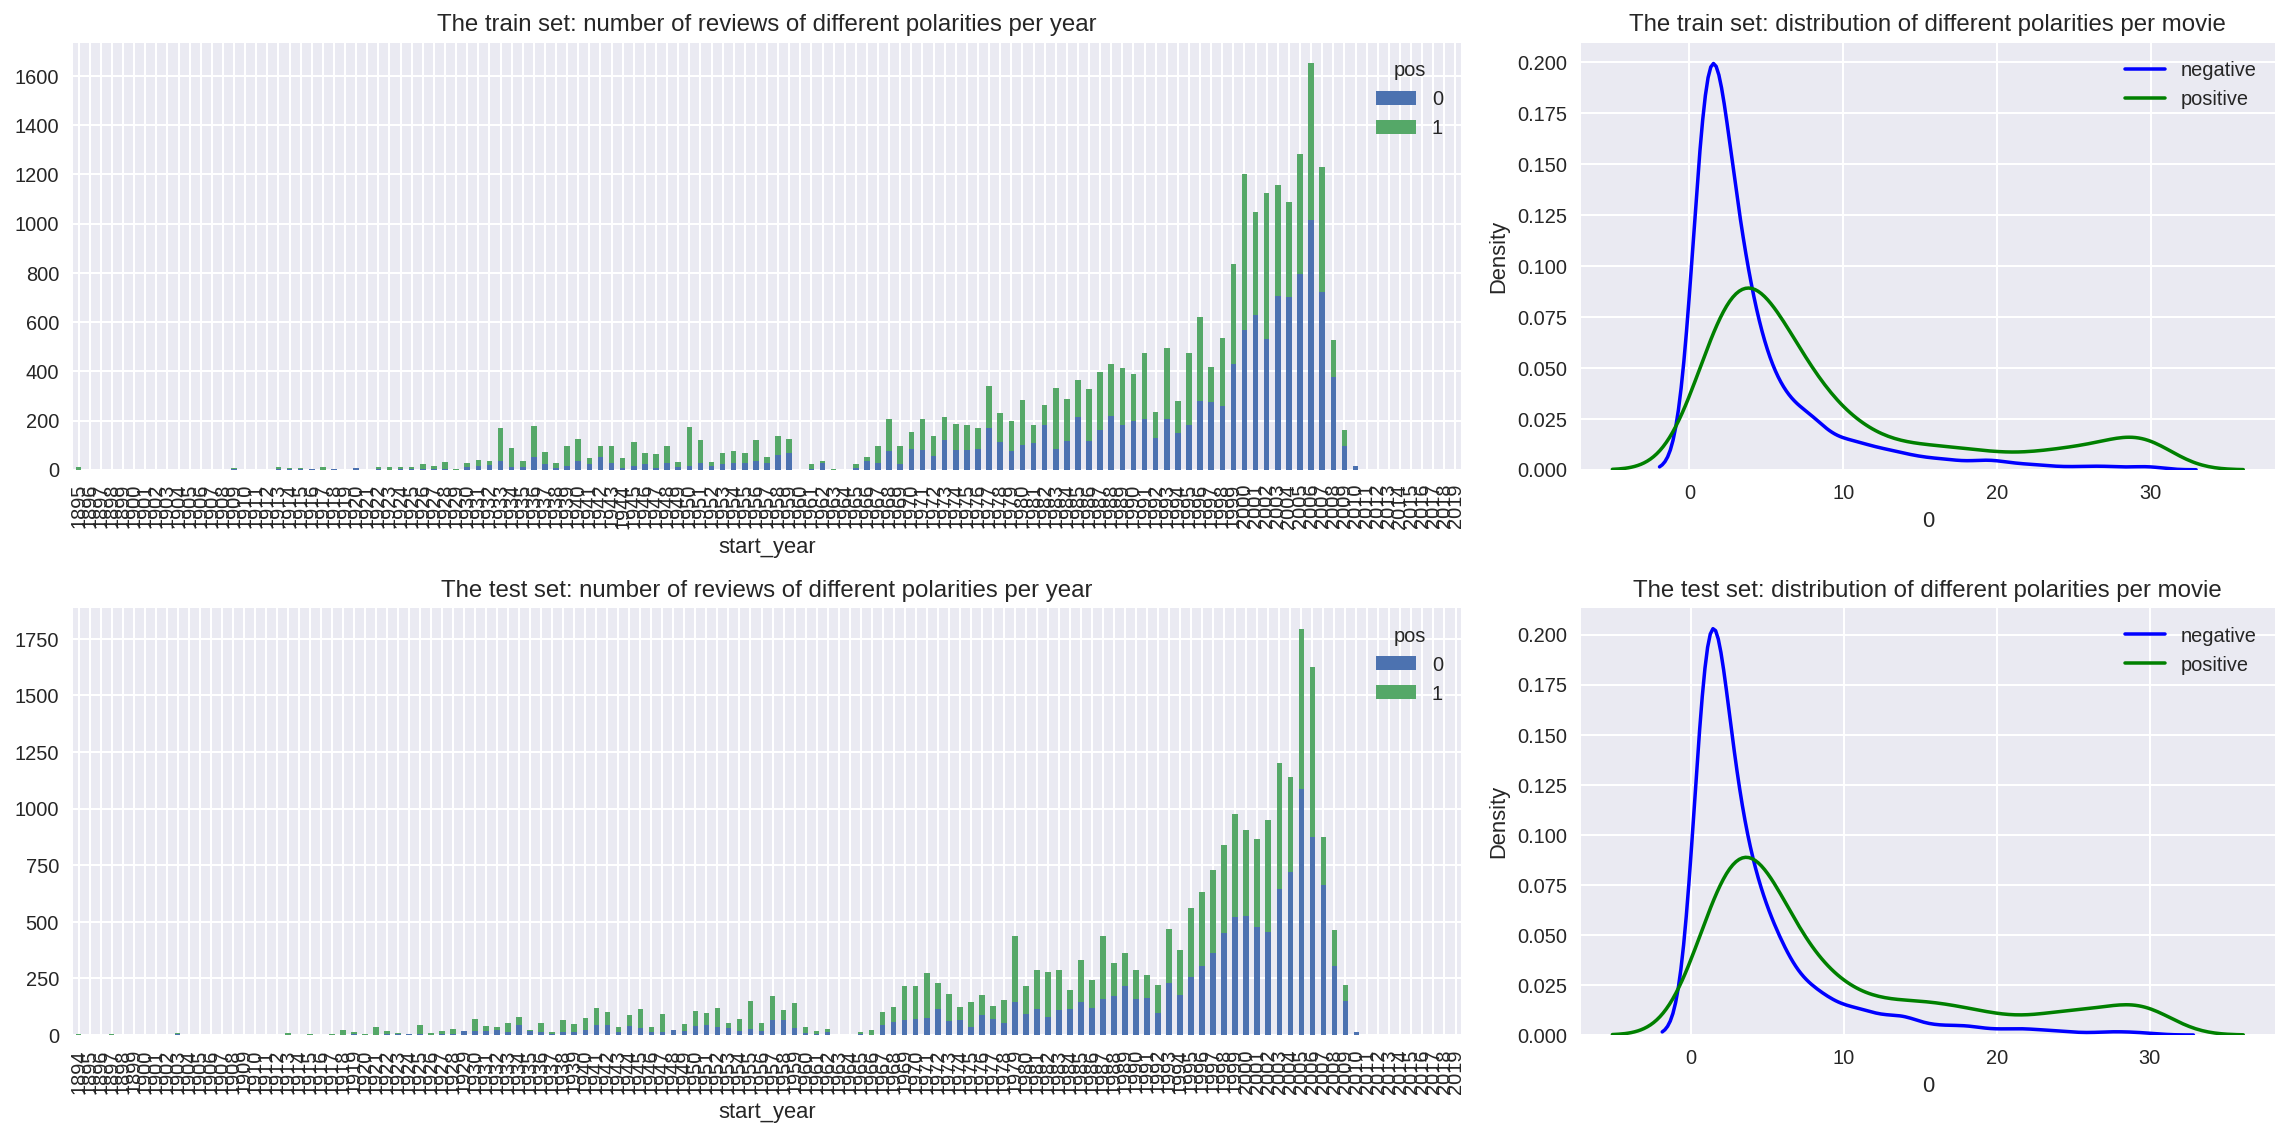

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

we can see that the distributions are very similar between the test and training datasets. Both are squewed. there is a dramatic increase of reviews starting in the 1990s. 

<div class="alert alert-success">
<b>Reviewer's comment</b>

Great, you explored the data and made some interesting observations!

</div>

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [19]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [20]:
def clear_text(text):

    clean_text = re.sub(r'[^a-zA-z\']', ' ', text)
    clean_text = " ".join(clean_text.split())

    return clean_text.lower()



In [21]:
df_reviews['review_norm'] =df_reviews['review'].apply(clear_text)
df_reviews['review_norm'].head()

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
2    there is no real story the film seems more lik...
3    um a serious film about troubled teens in sing...
4    i'm totally agree with garryjohal from singapo...
Name: review_norm, dtype: object

<div class="alert alert-success">
<b>Reviewer's comment</b>

The texts were normalized successfully!

</div>

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [22]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

y_train = df_reviews_train['pos']
y_test = df_reviews_test['pos']

X_train = df_reviews_train['review_norm']
X_test = df_reviews_test['review_norm']


print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


## Working with models

### Model 0 - Constant

In [23]:
%%time 
 
dummy_clf=DummyClassifier()
dummy_clf.fit(X_train,y_train)

CPU times: user 0 ns, sys: 3.22 ms, total: 3.22 ms
Wall time: 2.28 ms


DummyClassifier()

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


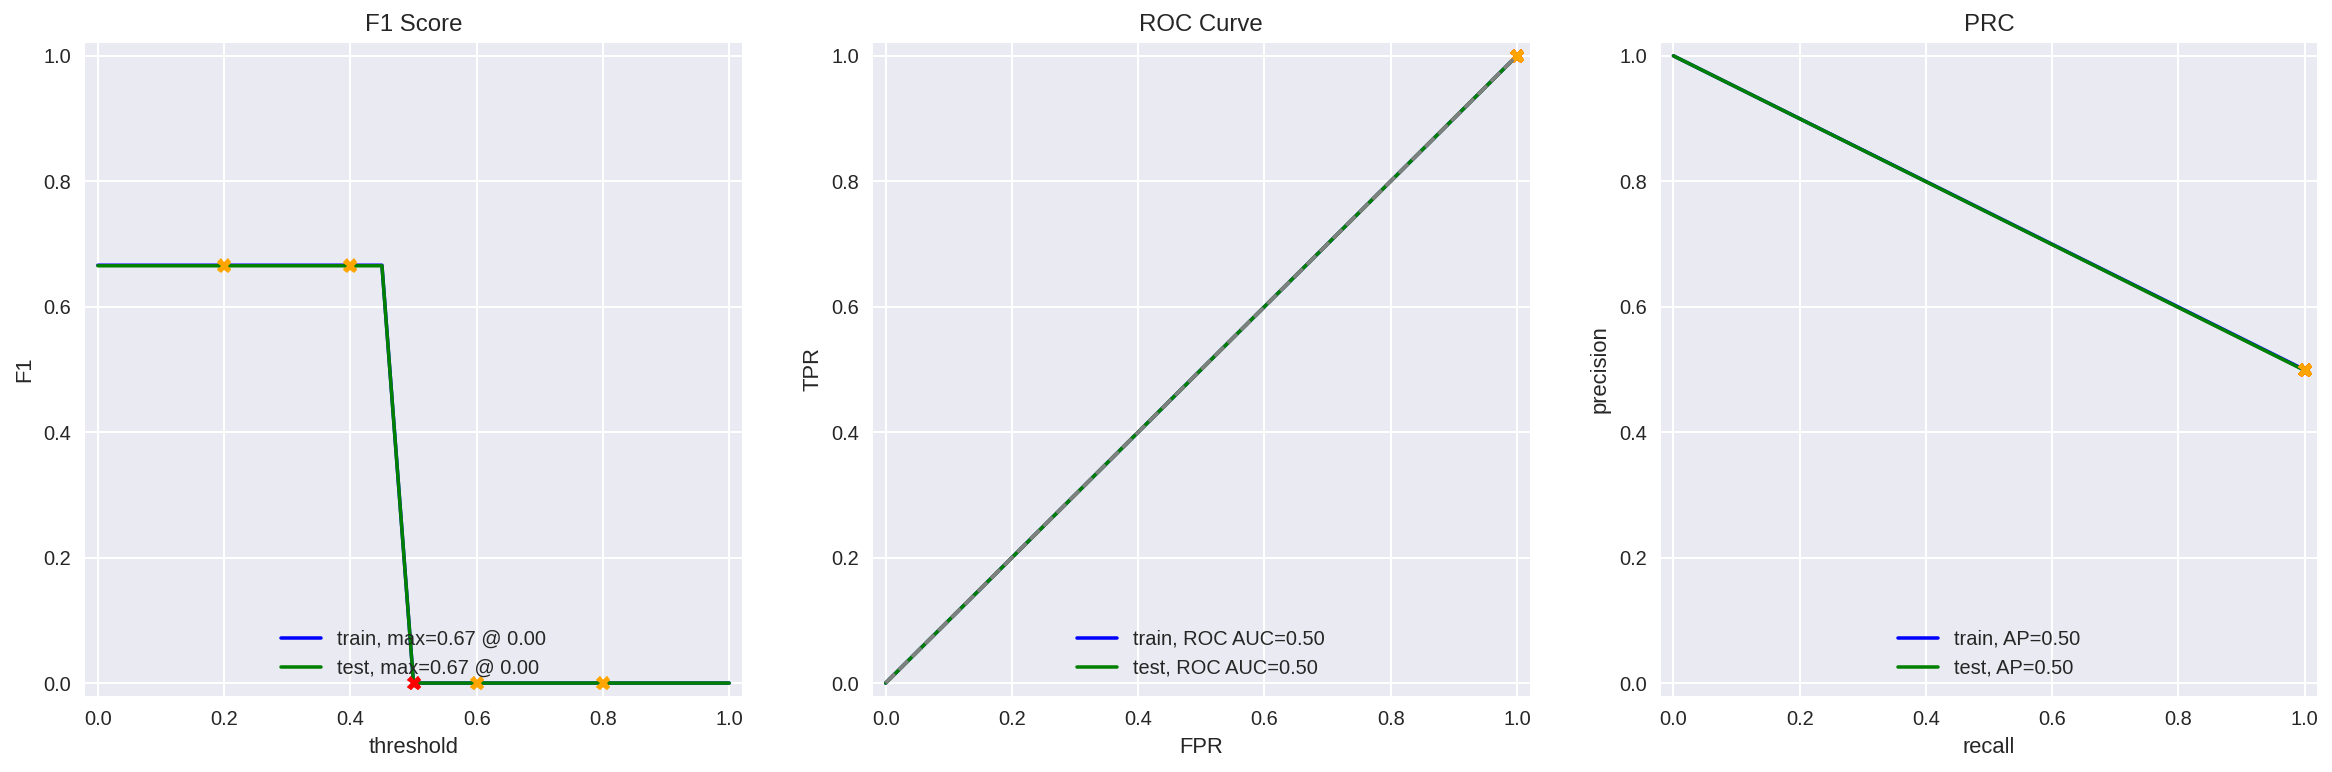

In [24]:
evaluate_model(dummy_clf, X_train, y_train, X_test, y_test)

The dummy classifier serves as the baseline for our models performance. Performing with 50% acurracy. And an F1 score of 0.5.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Good to have a simple baseline!

</div>

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [25]:
stop_words = set(stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words = stop_words)

def lemmatize_nltk(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text.lower())
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    lemmatized =" ".join(lemmas)
    return lemmatized

In [26]:
df_reviews_train['review_nltk']= X_train.apply(lemmatize_nltk)
df_reviews_test['review_nltk']=X_test.apply(lemmatize_nltk)

nltk_X_train = count_tf_idf.fit_transform(df_reviews_train['review_nltk'])
nltk_X_test = count_tf_idf.transform(df_reviews_test['review_nltk'])

In [27]:
%%time
# train logistic regression model
logistic_clf = LogisticRegression(random_state=12345, solver='liblinear')
logistic_clf.fit(nltk_X_train, y_train)

CPU times: user 827 ms, sys: 1.54 s, total: 2.37 s
Wall time: 2.32 s


LogisticRegression(random_state=12345, solver='liblinear')

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


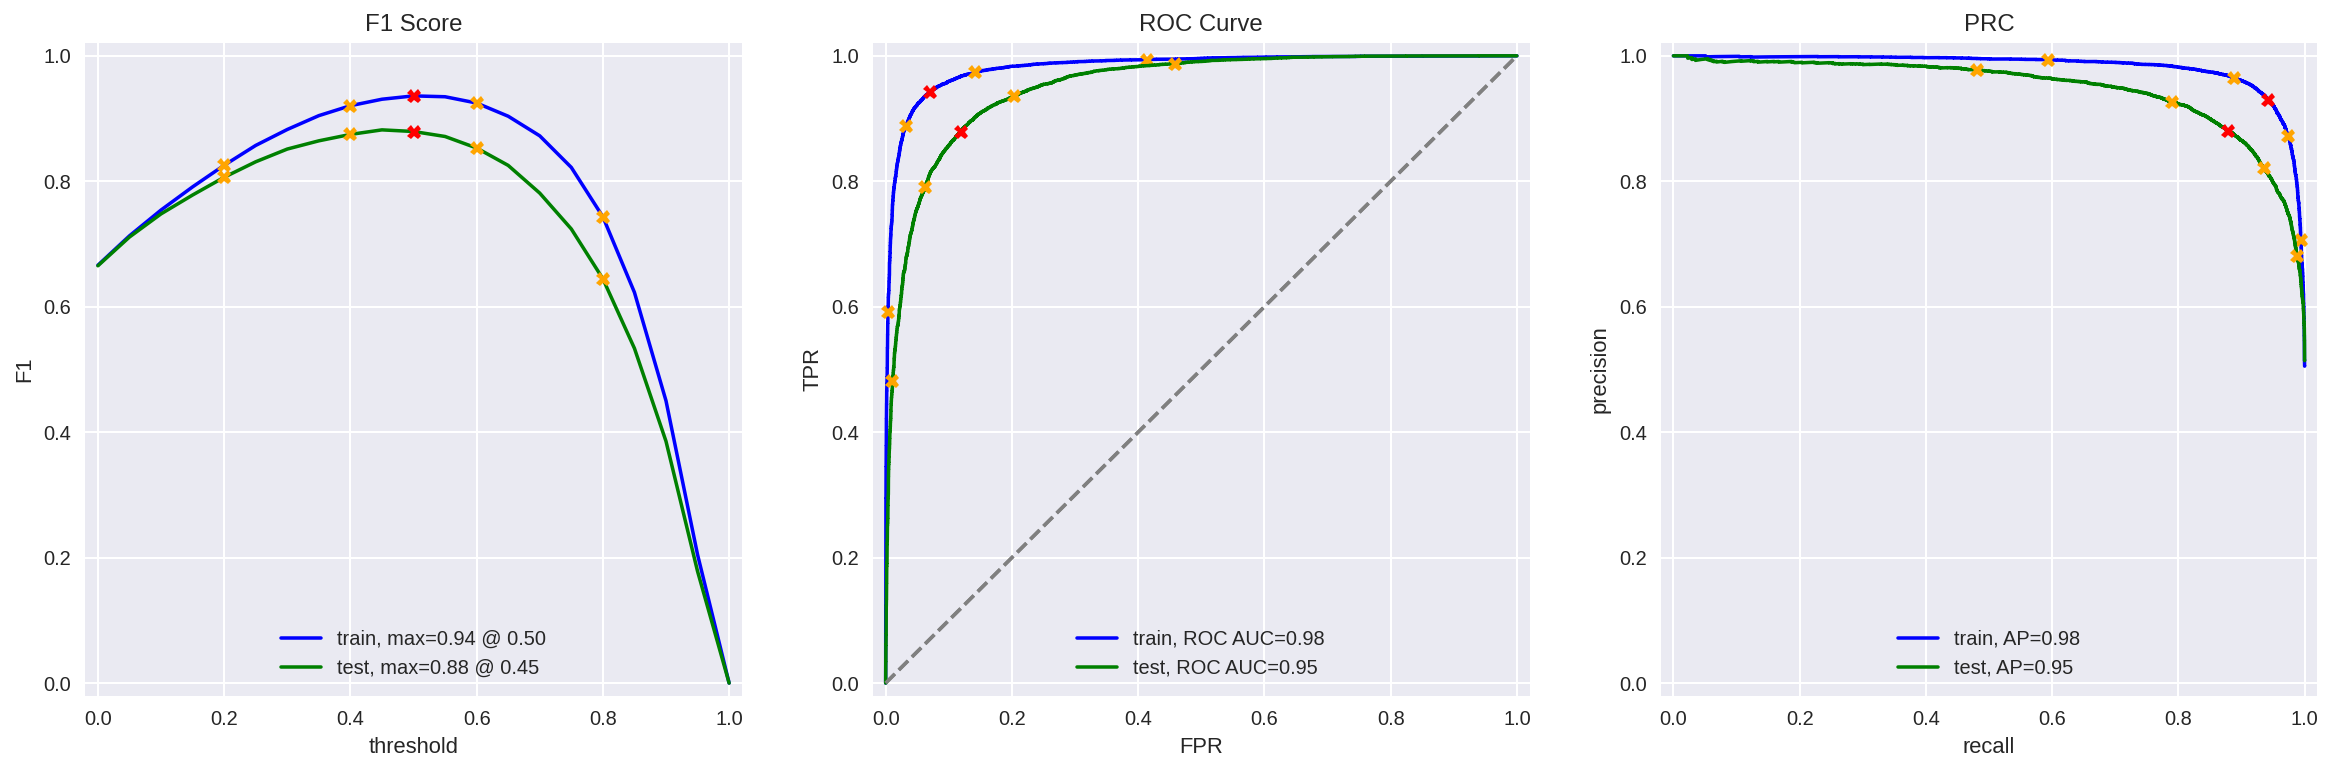

In [28]:
evaluate_model(logistic_clf, nltk_X_train, y_train, nltk_X_test, y_test)

For Logistic Regression the accuracy scored 88% and an F1 score of 0.88

### Model 3 - spaCy, TF-IDF and LR

In [29]:
def lemmatize_spacy(text):
    doc = nlp(text.lower())
    lemmas = []
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    lemmas = [token.lemma_ for token in doc]
    lemmatize_spacy = " ".join(lemmas)
    return lemmatize_spacy

In [30]:
df_reviews_train['review_spacy'] = X_train.apply(lemmatize_spacy)
df_reviews_test['review_spacy'] = X_test.apply(lemmatize_spacy)



In [31]:
# recalculate TF-IDF for train and test samples
spacy_X_train = count_tf_idf.fit_transform(df_reviews_train['review_spacy'])
spacy_X_test = count_tf_idf.transform(df_reviews_test['review_spacy'])

In [32]:
df_reviews_train['review_spacy'].head()

0    the pakage imply that warren beatty and goldie...
1    how the hell do they get this make present its...
7    this true story of carlson 's raider be more o...
8    should have be title ' balderdash ' little in ...
9    the movie ' gung ho ' the story of carlson 's ...
Name: review_spacy, dtype: object

#### Logistic Regression

In [33]:
%%time
# train logistic regression model
logistic_clf_spacy = LogisticRegression(random_state=12345, solver='liblinear')
logistic_clf_spacy.fit(spacy_X_train, y_train)

CPU times: user 718 ms, sys: 1.45 s, total: 2.17 s
Wall time: 2.12 s


LogisticRegression(random_state=12345, solver='liblinear')

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


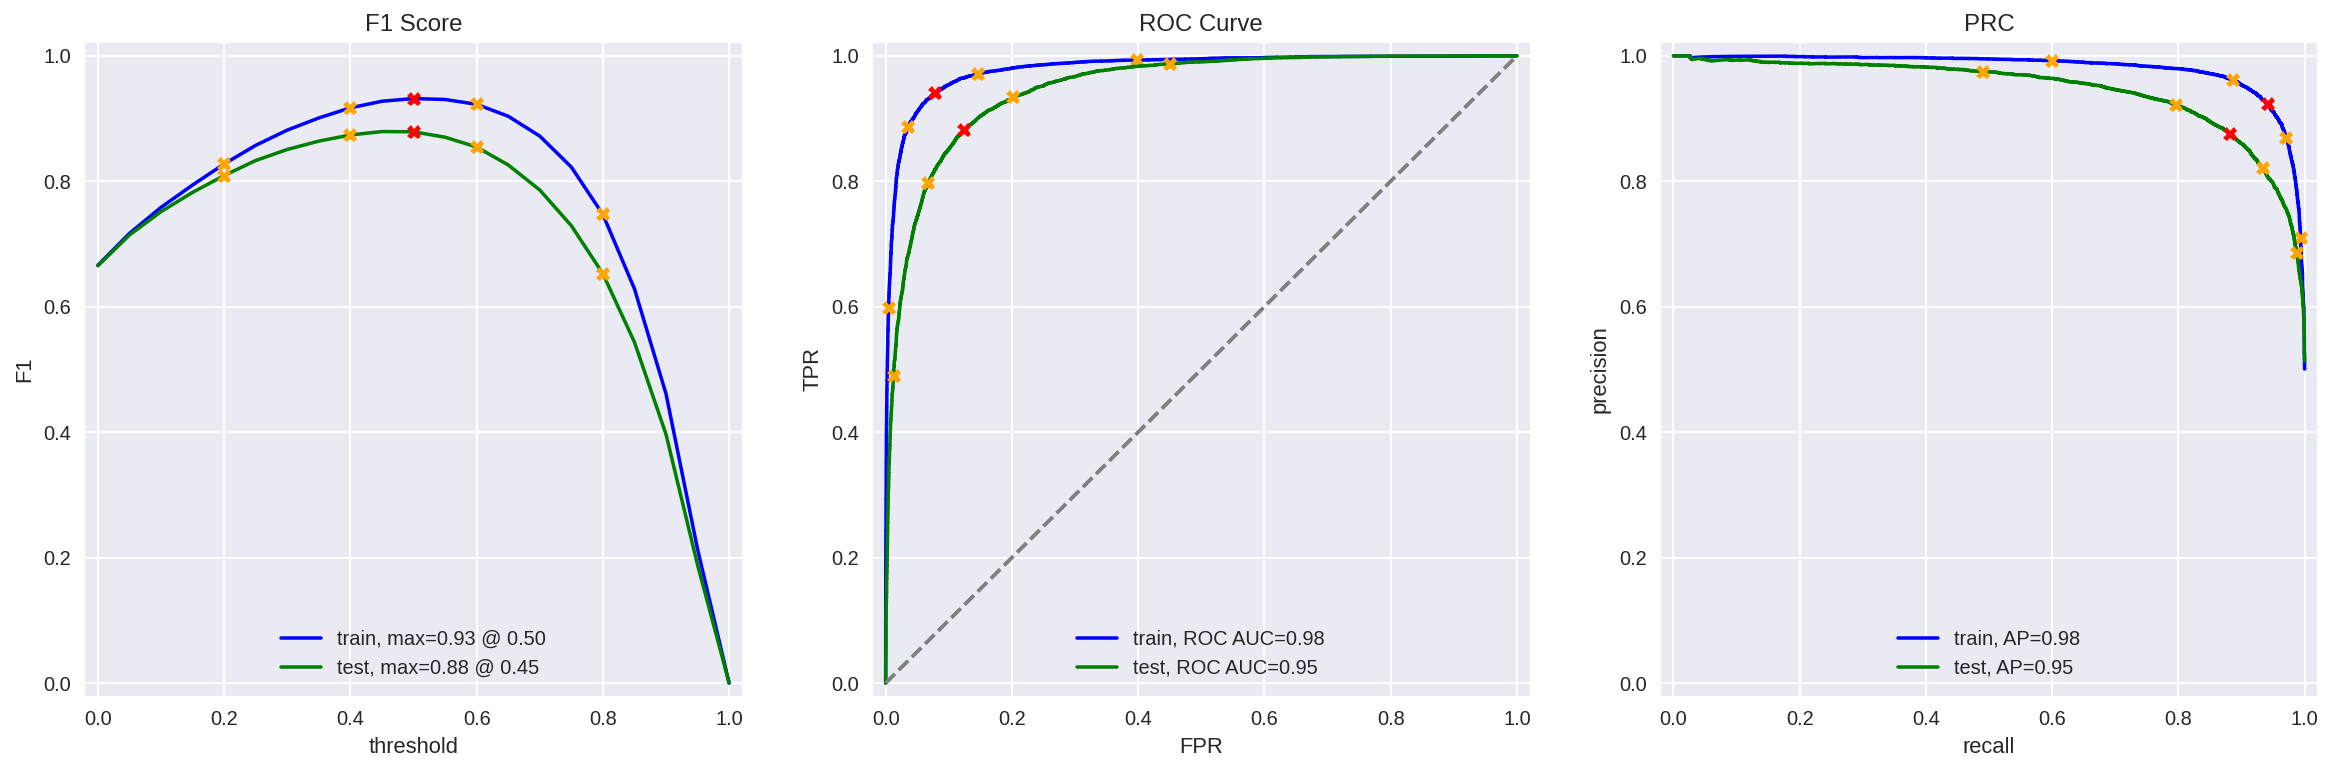

In [34]:
evaluate_model(logistic_clf_spacy, spacy_X_train, y_train, spacy_X_test, y_test)

spacy logistic regression scored the same as nltk logistic regression

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [35]:
%%time
# train lightGBM classifier
lgbm_clf_spacy = LGBMClassifier(random_state=12345)
lgbm_clf_spacy.fit(spacy_X_train, y_train)

CPU times: user 55.6 s, sys: 416 ms, total: 56 s
Wall time: 56.4 s


LGBMClassifier(random_state=12345)

          train  test
Accuracy   0.91  0.86
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


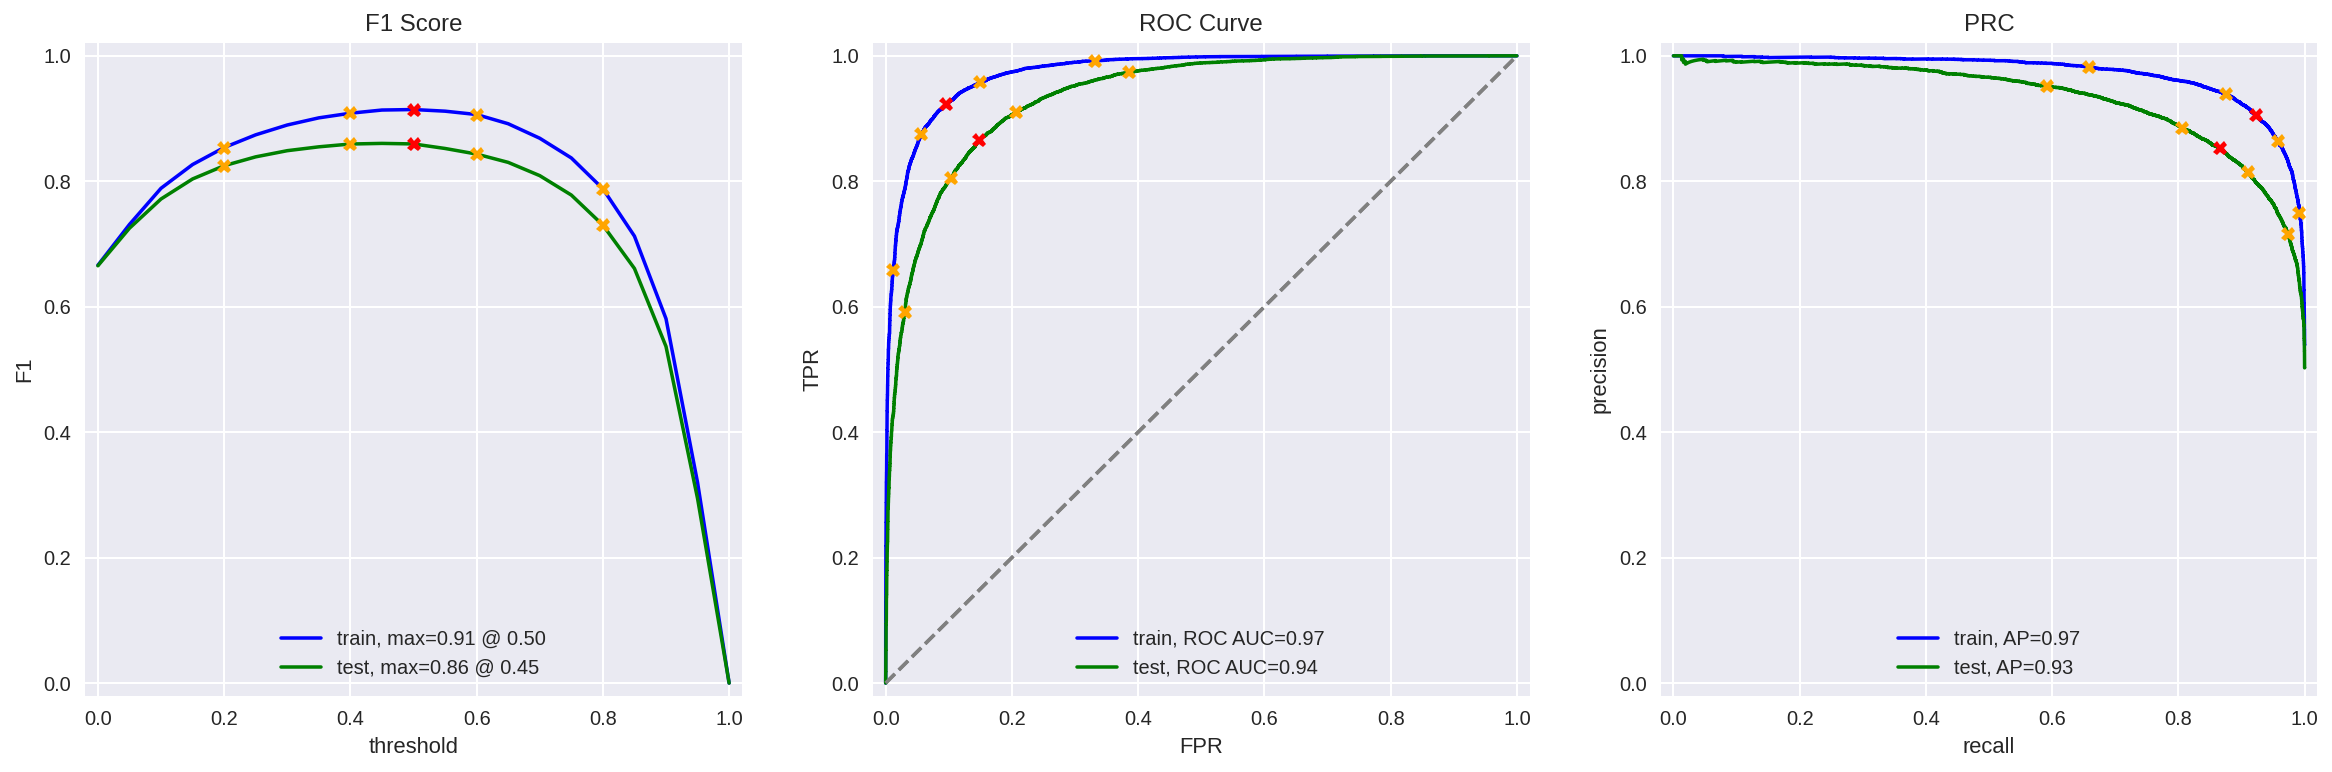

In [36]:
evaluate_model(lgbm_clf_spacy, spacy_X_train, y_train, spacy_X_test, y_test)

This model scores slightly lower but still passes the F1 threshold of .86 desired by the client

<div class="alert alert-success">
<b>Reviewer's comment</b>

You successfully vectorized text data and trained a couple of different models using the resulting features. It's nice that you tried lemmatization

</div>

## My Reviews

In [37]:

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(clear_text)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


### Model 2

In [38]:
texts = my_reviews['review_norm']

log_pred = logistic_clf_spacy.predict(count_tf_idf.transform(texts))
log_pred_prob = logistic_clf_spacy.predict_proba(count_tf_idf.transform(texts))[:, 1]

# summarize the result
print(f'{sum(log_pred)} were predicted as positive out of {len(log_pred)} reviews.')
print()
print('Pos:'+'  '+'Proba:'+'  '+'Actual review')
for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f'  {log_pred[i]}:   {log_pred_prob[i]:.2f}:  {review}')

1 were predicted as positive out of 8 reviews.

Pos:  Proba:  Actual review
  0:   0.20:  I did not simply like it, not my kind of movie.
  0:   0.12:  Well, I was bored and felt asleep in the middle of the movie.
  0:   0.49:  I was really fascinated with the movie
  0:   0.33:  Even the actors looked really old and disinterested, and they got paid to be in the movie. What a so
  0:   0.47:  I didn't expect the reboot to be so good! Writers really cared about the source material
  0:   0.47:  The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see my
  0:   0.07:  What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even ki
  1:   0.94:  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after epi


### Model 3

In [39]:
texts = my_reviews['review_norm']

# make predictions using lightGBM classifier
lgbm_pred = lgbm_clf_spacy.predict(count_tf_idf.transform(texts))
lgbm_pred_prob = lgbm_clf_spacy.predict_proba(count_tf_idf.transform(texts))[:, 1]

# summarize the result
print(f'{sum(lgbm_pred)} were predicted as positive out of {len(lgbm_pred)} reviews.')
print()
print('Pos:'+'  '+'Proba:'+'  '+'Actual review')
for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f'  {lgbm_pred[i]}:   {lgbm_pred_prob[i]:.2f}:  {review}')

5 were predicted as positive out of 8 reviews.

Pos:  Proba:  Actual review
  1:   0.57:  I did not simply like it, not my kind of movie.
  0:   0.42:  Well, I was bored and felt asleep in the middle of the movie.
  1:   0.61:  I was really fascinated with the movie
  0:   0.47:  Even the actors looked really old and disinterested, and they got paid to be in the movie. What a so
  1:   0.67:  I didn't expect the reboot to be so good! Writers really cared about the source material
  1:   0.67:  The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see my
  0:   0.26:  What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even ki
  1:   0.79:  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after epi


<div class="alert alert-success">
<b>Reviewer's comment</b>

The models were applied to new data correctly

</div>

## Conclusions

When testing with a small review set lightGBM with SpaCy, though logistic regression for nltk and spacy scored the best in training and testing, this model scored the best with the subset. Catching more positive reviews than the other two models. I recommend that Film  Junky Union move forward with LightGBM using SpaCy

<div class="alert alert-warning">
<b>Reviewer's comment</b>

It doesn't make sense to make any decisions based on a test set out of 8 examples :)

</div>

# Checklist

- [x]  Notebook was opened
- [ ]  The text data is loaded and pre-processed for vectorization
- [ ]  The text data is transformed to vectors
- [ ]  Models are trained and tested
- [ ]  The metric's threshold is reached
- [ ]  All the code cells are arranged in the order of their execution
- [ ]  All the code cells can be executed without errors
- [ ]  There are conclusions

Thank you for your time reviewing my project! 